# IMPORTS

In [69]:
!pip install -r requirements.txt
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/nightly/cpu

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Looking in indexes: https://download.pytorch.org/whl/nightly/cpu

[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip


In [70]:
import pandas as pd
from prophet import Prophet
import polars as pl
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.base import BaseEstimator, TransformerMixin
from datetime import datetime
from sklearn.impute import SimpleImputer

from transformers import AutoModelForSeq2SeqLM, AutoTokenizer, AutoModel
import torch
import pickle



# DATA READ

In [71]:

df_petrovich = pd.read_parquet('data/saturn_petrovich.parquet', engine='pyarrow')
df_leroy = pd.read_parquet('data/saturn_leroy.parquet', engine='pyarrow')


# EDA

## Shape and Variable Types

In [72]:
print("Petrovich DataFrame:")
display(df_petrovich.head())
print(df_petrovich.columns)

print("\nLeroy DataFrame:")
display(df_leroy.head())
print(df_leroy.columns)


Petrovich DataFrame:


,match_type,category_1,category_2,category_3,category_4,category_5,sku,brand,our_price,price,price_before_discount,date,city,status,competitor
0,1,Стройматериалы,"Кровля, водосточные системы",Гибкая черепица и комплектующие,Комплектующие для гибкой черепицы,None,600877_м2,ТЕХНОНИКОЛЬ,2049.0,137.940002,NaN,2024-10-07,1,1,petrovich
1,1,Стройматериалы,"Кровля, водосточные системы",Профнастил и оцинкованные листы,Профнастил и комплектующие,None,106643_м2,None,NaN,673.469971,NaN,2024-10-07,1,1,petrovich
2,1,Стройматериалы,"Кровля, водосточные системы",Профнастил и оцинкованные листы,Профнастил и комплектующие,None,106644_м2,КОРИЧНЕВЫЙ,NaN,639.130005,NaN,2024-10-07,1,1,petrovich
3,1,Стройматериалы,"Кровля, водосточные системы",Профнастил и оцинкованные листы,Профнастил и комплектующие,None,143965_м2,None,NaN,630.320007,NaN,2024-10-07,1,1,petrovich
4,1,Стройматериалы,"Кровля, водосточные системы",Профнастил и оцинкованные листы,Профнастил и комплектующие,None,106642_м2,None,NaN,543.039978,NaN,2024-10-07,1,1,petrovich


Index(['match_type', 'category_1', 'category_2', 'category_3', 'category_4',
       'category_5', 'sku', 'brand', 'our_price', 'price',
       'price_before_discount', 'date', 'city', 'status', 'competitor'],
      dtype='object')

Leroy DataFrame:


,match_type,category_1,category_2,category_3,category_4,category_5,sku,brand,our_price,price,price_before_discount,date,city,status,competitor
0,0,None,None,None,None,None,10009818,glims,NaN,0.000000,NaN,2024-07-08,1,0,lerua
1,0,None,None,None,None,None,10009818,glims,NaN,0.000000,NaN,2024-07-22,1,0,lerua
2,0,None,None,None,None,None,10009818,glims,NaN,1108.000000,NaN,2024-09-23,1,0,lerua
3,0,None,None,None,None,None,10009818,glims,NaN,1108.000000,NaN,2024-09-30,2,0,lerua
4,0,None,None,None,None,None,10009818_кг,None,NaN,55.400002,NaN,2024-09-23,1,0,lerua


Index(['match_type', 'category_1', 'category_2', 'category_3', 'category_4',
       'category_5', 'sku', 'brand', 'our_price', 'price',
       'price_before_discount', 'date', 'city', 'status', 'competitor'],
      dtype='object')


In [73]:
print("Petrovich DataFrame shape:", df_petrovich.shape)
print("Leroy DataFrame shape:", df_leroy.shape)


Petrovich DataFrame shape: (2313025, 15)
Leroy DataFrame shape: (41789958, 15)


## Feature Exploration

In [74]:
unique_categories_petrovich = df_petrovich['category_1'].nunique()
unique_categories_leroy = df_leroy['category_1'].nunique()

print("Unique categories in category_1 for Petrovich DataFrame:", unique_categories_petrovich)
print("Unique categories in category_1 for Leroy DataFrame:", unique_categories_leroy)



Unique categories in category_1 for Petrovich DataFrame: 237
Unique categories in category_1 for Leroy DataFrame: 6813


In [75]:
# Count unique brands in each dataset
unique_brands_petrovich = df_petrovich['brand'].nunique()
unique_brands_leroy = df_leroy['brand'].nunique()

# Print the results
print("Unique brands in Petrovich DataFrame:", unique_brands_petrovich)
print("Unique brands in Leroy DataFrame:", unique_brands_leroy)


Unique brands in Petrovich DataFrame: 863
Unique brands in Leroy DataFrame: 4542


In [76]:
df_built = df_petrovich[df_petrovich['category_1'] == 'Стройматериалы']
category_with_price_count = df_built[df_built['our_price'].notna()].shape[0]
print("Number of rows corresponding to category_1 'Стройматериалы' with 'our_price' as a value:", category_with_price_count)


Number of rows corresponding to category_1 'Стройматериалы' with 'our_price' as a value: 28943


In [77]:
df_built.head()

,match_type,category_1,category_2,category_3,category_4,category_5,sku,brand,our_price,price,price_before_discount,date,city,status,competitor
0,1,Стройматериалы,"Кровля, водосточные системы",Гибкая черепица и комплектующие,Комплектующие для гибкой черепицы,None,600877_м2,ТЕХНОНИКОЛЬ,2049.0,137.940002,NaN,2024-10-07,1,1,petrovich
1,1,Стройматериалы,"Кровля, водосточные системы",Профнастил и оцинкованные листы,Профнастил и комплектующие,None,106643_м2,None,NaN,673.469971,NaN,2024-10-07,1,1,petrovich
2,1,Стройматериалы,"Кровля, водосточные системы",Профнастил и оцинкованные листы,Профнастил и комплектующие,None,106644_м2,КОРИЧНЕВЫЙ,NaN,639.130005,NaN,2024-10-07,1,1,petrovich
3,1,Стройматериалы,"Кровля, водосточные системы",Профнастил и оцинкованные листы,Профнастил и комплектующие,None,143965_м2,None,NaN,630.320007,NaN,2024-10-07,1,1,petrovich
4,1,Стройматериалы,"Кровля, водосточные системы",Профнастил и оцинкованные листы,Профнастил и комплектующие,None,106642_м2,None,NaN,543.039978,NaN,2024-10-07,1,1,petrovich


In [78]:
# Check the unique values for 'city' and 'status'
city_unique_values = df_built['city'].unique()
status_unique_values = df_built['status'].unique()

# Count the occurrences of each value in 'city' and 'status'
city_value_counts = df_built['city'].value_counts()
status_value_counts = df_built['status'].value_counts()

# Display the results
print("Unique values in 'city':", city_unique_values)
print("Value counts for 'city':\n", city_value_counts)
print("\nUnique values in 'status':", status_unique_values)
print("Value counts for 'status':\n", status_value_counts)


Unique values in 'city': [1]
Value counts for 'city':
 city
1    157440
Name: count, dtype: int64

Unique values in 'status': [1 0 2 3 4]
Value counts for 'status':
 status
1    140009
0     17264
2        79
3        50
4        38
Name: count, dtype: int64


In [79]:
# Calculate the range (min and max) for 'price', 'our_price', and 'price_before_discount'
price_range = (df_built['price'].min(), df_built['price'].max())
our_price_range = (df_built['our_price'].min(), df_built['our_price'].max())
price_before_discount_range = (df_built['price_before_discount'].min(), df_built['price_before_discount'].max())

# Display the results
print("Range of 'price':", price_range)
print("Range of 'our_price':", our_price_range)
print("Range of 'price_before_discount':", price_before_discount_range)


Range of 'price': (np.float32(0.0), np.float32(147100.0))
Range of 'our_price': (np.float32(9.0), np.float32(18730.0))
Range of 'price_before_discount': (np.float32(3.1), np.float32(131470.0))


In [80]:
df_built.describe()

,match_type,our_price,price,price_before_discount,city,status
count,157440.000000,28943.000000,157440.000000,67513.000000,157440.0,157440.000000
mean,0.252757,1397.909912,2355.168213,1838.401611,1.0,0.892207
std,0.449848,1957.484741,7036.827637,3863.724854,0.0,0.319343
min,0.000000,9.000000,0.000000,3.100000,1.0,0.000000
25%,0.000000,378.000000,279.929993,408.000000,1.0,1.000000
50%,0.000000,745.000000,789.000000,880.000000,1.0,1.000000
75%,0.000000,1608.000000,1881.219971,1804.000000,1.0,1.000000
max,2.000000,18730.000000,147100.000000,131470.000000,1.0,4.000000


In [81]:
# Calculate unique values for each category in both dataframes
unique_values_leroy = {col: set(df_leroy[col].unique()) for col in ['category_1', 'category_2', 'category_3', 'category_4', 'category_5']}
unique_values_petrovich = {col: set(df_petrovich[col].unique()) for col in ['category_1', 'category_2', 'category_3', 'category_4', 'category_5']}

# Display unique counts for each category in df_leroy
unique_counts_leroy = {col: len(unique_values_leroy[col]) for col in unique_values_leroy}
for category, count in unique_counts_leroy.items():
    print(f"{category} in df_leroy: {count} unique values")

# Display unique counts for each category in df_petrovich
unique_counts_petrovich = {col: len(unique_values_petrovich[col]) for col in unique_values_petrovich}
for category, count in unique_counts_petrovich.items():
    print(f"{category} in df_petrovich: {count} unique values")

# Check for overlap and display count of matches
for col in unique_values_leroy:
    matches = unique_values_leroy[col].intersection(unique_values_petrovich[col])
    match_count = len(matches)
    print(f"\nCount of matching values in {col}: {match_count}")

# Optional: Display counts of each unique value within each category in df_petrovich
for col in ['category_1', 'category_2', 'category_3', 'category_4', 'category_5']:
    print(f"\nCounts for {col} in df_petrovich:")
    print(df_petrovich[col].value_counts())


category_1 in df_leroy: 6814 unique values
category_2 in df_leroy: 349 unique values
category_3 in df_leroy: 1764 unique values
category_4 in df_leroy: 32 unique values
category_5 in df_leroy: 14 unique values
category_1 in df_petrovich: 237 unique values
category_2 in df_petrovich: 144 unique values
category_3 in df_petrovich: 969 unique values
category_4 in df_petrovich: 2075 unique values
category_5 in df_petrovich: 676 unique values

Count of matching values in category_1: 19

Count of matching values in category_2: 22

Count of matching values in category_3: 144

Count of matching values in category_4: 2

Count of matching values in category_5: 1

Counts for category_1 in df_petrovich:
category_1
Электрика                     630516
Финишная отделка              401088
Инструмент                    291919
Инженерные системы            269831
Товары для дома               219023
                               ...  
Распределительные щиты EKF         1
Дрели Makita                  

In [82]:
# Step 1: Calculate the top N (5) most frequent values for each category
top_n = 5
category_columns = ['category_1', 'category_2', 'category_3', 'category_4', 'category_5']
top_n = 5
top_n_percentage_non_nan = {}

for col in category_columns:
    # Calculate the top N values as a percentage of non-NaN counts
    non_nan_count = df_petrovich[col].notna().sum()
    top_n_values = (df_petrovich[col].value_counts(normalize=True, dropna=True).head(top_n) * 100).round(2)
    top_n_percentage_non_nan[col] = top_n_values
    print(f"\nTop 5 values in {col} as a percentage of non-NaN data points ({non_nan_count} non-NaN values):")
    for value, percentage in top_n_values.items():
        print(f"  {value}: {percentage:.2f}%")



Top 5 values in category_1 as a percentage of non-NaN data points (2313025 non-NaN values):
  Электрика: 27.26%
  Финишная отделка: 17.34%
  Инструмент: 12.62%
  Инженерные системы: 11.67%
  Товары для дома: 9.47%

Top 5 values in category_2 as a percentage of non-NaN data points (2312480 non-NaN values):
  Освещение: 13.59%
  Водоснабжение: 4.75%
  Розетки, выключатели: 4.46%
  Керамическая плитка и затирки: 3.85%
  Напольные покрытия: 3.66%

Top 5 values in category_3 as a percentage of non-NaN data points (2283620 non-NaN values):
  Освещение жилых помещений: 10.58%
  Автоматические выключатели: 2.05%
  Бытовая техника для кухни: 1.64%
  Керамогранит: 1.59%
  Мебельная фурнитура: 1.56%

Top 5 values in category_4 as a percentage of non-NaN data points (1386281 non-NaN values):
  Люстры: 3.87%
  Трековые системы: 3.15%
  Бра и подсветка: 2.43%
  Подвесные светильники: 1.91%
  Автоматические выключатели модульные: 1.72%

Top 5 values in category_5 as a percentage of non-NaN data poin

# Feature Engineering

1. Encoding Ordinal match_type variable into three features 

In [83]:
df_built['No Match'] = (df_built['match_type'] == 0).astype(int)
df_built['100% Match'] = (df_built['match_type'] == 1).astype(int)
df_built['Exclusive'] = (df_built['match_type'] == 2).astype(int)

print("Count of No Match:", df_built['No Match'].sum())
print("Count of 100% Match:", df_built['100% Match'].sum())
print("Count of Exclusive:", df_built['Exclusive'].sum())


Count of No Match: 118708
Count of 100% Match: 37670
Count of Exclusive: 1062


/var/folders/zc/5d6j4pzj2wz21d9qzfwd9q8h0000gn/T/ipykernel_91962/1203702939.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_built['No Match'] = (df_built['match_type'] == 0).astype(int)
/var/folders/zc/5d6j4pzj2wz21d9qzfwd9q8h0000gn/T/ipykernel_91962/1203702939.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_built['100% Match'] = (df_built['match_type'] == 1).astype(int)
/var/folders/zc/5d6j4pzj2wz21d9qzfwd9q8h0000gn/T/ipykernel_91962/1203702939.py:3: SettingWithCopyWarning: 
A value is trying

In [84]:
# Define the status mapping
status_mapping = {
    2: "on_order",
    1: "in_stock",
    3: "expected",
    4: "status_not_defined",
    0: "out_of_stock"
}

# Map the status column to the new feature names
df_built['status'] = df_built['status'].map(status_mapping)

# One-hot encode the 'status' column, preserving other columns
df_built = pd.get_dummies(df_built, columns=['status'], prefix='', prefix_sep='')



/var/folders/zc/5d6j4pzj2wz21d9qzfwd9q8h0000gn/T/ipykernel_91962/2319820689.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_built['status'] = df_built['status'].map(status_mapping)


**Translating the categories**
using https://nllb.metademolab.com
https://huggingface.co/docs/transformers/main/en/model_doc/nllb#nllb

In [85]:
!pip install transformers torch sentencepiece

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip


In [87]:


# Load translation model and tokenizer
translation_model_name = "Helsinki-NLP/opus-mt-ru-en"
translation_tokenizer = AutoTokenizer.from_pretrained(translation_model_name)
translation_model = AutoModelForSeq2SeqLM.from_pretrained(translation_model_name)

# Load embedding model and tokenizer
embedding_model_name = "sentence-transformers/all-MiniLM-L6-v2"
embedding_tokenizer = AutoTokenizer.from_pretrained(embedding_model_name)
embedding_model = AutoModel.from_pretrained(embedding_model_name)

# Move models to GPU if available
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("Using CUDA (GPU) for computation.")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
    print("Using MPS (Apple Silicon) for computation.")
else:
    device = torch.device("cpu")
    print("Using CPU for computation.")

translation_model = translation_model.to(device)
embedding_model = embedding_model.to(device)

def batch_translate(texts, batch_size=16):
    translations = []
    for i in range(0, len(texts), batch_size):
        batch = texts[i:i+batch_size]
        # Ensure batch is a list of non-empty strings
        batch = [text for text in batch if text.strip()]
        if not batch:
            continue
        inputs = translation_tokenizer(batch, return_tensors="pt", padding=True, truncation=True).to(device)
        target_lang_id = translation_tokenizer.convert_tokens_to_ids("eng_Latn")
        translated_tokens = translation_model.generate(
            **inputs,
            forced_bos_token_id=target_lang_id,
            max_length=100,
            num_beams=4,
            early_stopping=True
        )
        outputs = translation_tokenizer.batch_decode(translated_tokens, skip_special_tokens=True)
        translations.extend(outputs)
    return translations

# Batch embedding function
def batch_compute_embeddings(text_list, batch_size=64):
    embeddings = []
    for i in range(0, len(text_list), batch_size):
        batch = text_list[i:i+batch_size]
        inputs = embedding_tokenizer(batch, return_tensors="pt", padding=True, truncation=True).to(device)
        with torch.no_grad():
            outputs = embedding_model(**inputs)
            batch_embeddings = outputs.last_hidden_state.mean(dim=1)  # Mean pooling
            embeddings.extend(batch_embeddings.cpu().numpy())
    return embeddings



/Users/nathancarey/ecom/myenv/lib/python3.11/site-packages/transformers/models/marian/tokenization_marian.py:175: UserWarning: Recommended: pip install sacremoses.
  warnings.warn("Recommended: pip install sacremoses.")


Using MPS (Apple Silicon) for computation.


In [88]:
# List of columns to process
columns_to_translate = ['category_1', 'category_2', 'category_3', 'category_4', 'category_5']

**Dataframe Class to tokenise -> Translate -> Embed**

In [ ]:
class DataFrameProcessor:
    def __init__(self, df, columns, tokenizer, translator, embedder):
        self.df = df
        self.columns = columns
        self.tokenizer = tokenizer
        self.translator = translator
        self.embedder = embedder
        self.hash_tables = {}
        self.embedding_tables = {}

    def process(self):
        for col in self.columns:
            self._process_column(col)
        self._apply_embeddings()

    def _process_column(self, col):
        unique_values = self.df[col].dropna().unique()
        unique_values = [str(value) for value in unique_values if str(value).strip()]

        # Tokenize
        inputs = self.tokenizer(unique_values, return_tensors="pt", padding=True, truncation=True)
        print(f"Tokenized input for {col}: {inputs}")

        # Translate
        translations = self.translator(unique_values)
        print(f"Translations for {col}: {translations[:5]}")

        # Embed
        embeddings = self.embedder(translations)
        print(f"Embeddings for {col}: {embeddings[:5]}")

        # Create hash and embedding tables
        self.hash_tables[col] = dict(zip(unique_values, translations))
        self.embedding_tables[col] = dict(zip(translations, embeddings))

    def _apply_embeddings(self):
        self.df['embeddings'] = self.df.apply(self._map_to_embeddings, axis=1)

    def _map_to_embeddings(self, row):
        embedding_size = 384
        embeddings = []
        for col in self.columns:
            value = row[col]
            translation = self.hash_tables[col].get(value, None)
            if translation:
                embedding = self.embedding_tables[col].get(translation, None)
                if embedding is not None:
                    embeddings.extend(embedding)
                else:
                    print(f"Missing embedding for translation: {translation}")
                    embeddings.extend([0] * embedding_size)
            else:
                print(f"Missing translation for value: {value}")
                embeddings.extend([0] * embedding_size)
        return np.array(embeddings)


**Initialize and process the DataFrame**

In [ ]:
processor = DataFrameProcessor(df_built, columns_to_translate, translation_tokenizer, batch_translate, batch_compute_embeddings)
processor.process()

In [ ]:
print("\nSample row embeddings:")
print(df_built['embeddings'].head())

In [91]:
df_built.head()

,match_type,category_1,category_2,category_3,category_4,category_5,sku,brand,our_price,price,...,competitor,No Match,100% Match,Exclusive,expected,in_stock,on_order,out_of_stock,status_not_defined,embeddings
0,1,Стройматериалы,"Кровля, водосточные системы",Гибкая черепица и комплектующие,Комплектующие для гибкой черепицы,None,600877_м2,ТЕХНОНИКОЛЬ,2049.0,137.940002,...,petrovich,0,1,0,False,True,False,False,False,"[-0.5306603908538818, 0.23424945771694183, -0...."
1,1,Стройматериалы,"Кровля, водосточные системы",Профнастил и оцинкованные листы,Профнастил и комплектующие,None,106643_м2,None,NaN,673.469971,...,petrovich,0,1,0,False,True,False,False,False,"[-0.5306603908538818, 0.23424945771694183, -0...."
2,1,Стройматериалы,"Кровля, водосточные системы",Профнастил и оцинкованные листы,Профнастил и комплектующие,None,106644_м2,КОРИЧНЕВЫЙ,NaN,639.130005,...,petrovich,0,1,0,False,True,False,False,False,"[-0.5306603908538818, 0.23424945771694183, -0...."
3,1,Стройматериалы,"Кровля, водосточные системы",Профнастил и оцинкованные листы,Профнастил и комплектующие,None,143965_м2,None,NaN,630.320007,...,petrovich,0,1,0,False,True,False,False,False,"[-0.5306603908538818, 0.23424945771694183, -0...."
4,1,Стройматериалы,"Кровля, водосточные системы",Профнастил и оцинкованные листы,Профнастил и комплектующие,None,106642_м2,None,NaN,543.039978,...,petrovich,0,1,0,False,True,False,False,False,"[-0.5306603908538818, 0.23424945771694183, -0...."


In [20]:
#df_built = df_built.drop(columns=['category_5', 'category_4', 'category_3', 'category_2'])

In [21]:
#df_built = df_built.drop(columns=['city', 'match_type', 'category_1', 'competitor'])

In [22]:
df_built.head()

,match_type,category_1,category_2,category_3,category_4,category_5,sku,brand,our_price,price,...,city,competitor,No Match,100% Match,Exclusive,expected,in_stock,on_order,out_of_stock,status_not_defined
0,1,s,"s, draining systems",skulls and components,skulls set,None,600877_м2,ТЕХНОНИКОЛЬ,2049.0,137.940002,...,1,petrovich,0,1,0,False,True,False,False,False
1,1,s,"s, draining systems",and zinc sheets,s and components,None,106643_м2,None,NaN,673.469971,...,1,petrovich,0,1,0,False,True,False,False,False
2,1,s,"s, draining systems",and zinc sheets,s and components,None,106644_м2,КОРИЧНЕВЫЙ,NaN,639.130005,...,1,petrovich,0,1,0,False,True,False,False,False
3,1,s,"s, draining systems",and zinc sheets,s and components,None,143965_м2,None,NaN,630.320007,...,1,petrovich,0,1,0,False,True,False,False,False
4,1,s,"s, draining systems",and zinc sheets,s and components,None,106642_м2,None,NaN,543.039978,...,1,petrovich,0,1,0,False,True,False,False,False


In [23]:
# Map True and False to 1 and 0 in the specified columns
columns_to_map = ['expected', 'in_stock', 'on_order', 'out_of_stock', 'status_not_defined']
df_built[columns_to_map] = df_built[columns_to_map].astype(int)

In [25]:
df_built.describe()

,match_type,our_price,price,price_before_discount,city,No Match,100% Match,Exclusive,expected,in_stock,on_order,out_of_stock,status_not_defined
count,157440.000000,28943.000000,157440.000000,67513.000000,157440.0,157440.000000,157440.000000,157440.000000,157440.000000,157440.000000,157440.000000,157440.000000,157440.000000
mean,0.252757,1397.909912,2355.168213,1838.401611,1.0,0.753989,0.239266,0.006745,0.000318,0.889285,0.000502,0.109654,0.000241
std,0.449848,1957.484741,7036.827637,3863.724854,0.0,0.430686,0.426637,0.081853,0.017818,0.313780,0.022395,0.312460,0.015534
min,0.000000,9.000000,0.000000,3.100000,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,378.000000,279.929993,408.000000,1.0,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
50%,0.000000,745.000000,789.000000,880.000000,1.0,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
75%,0.000000,1608.000000,1881.219971,1804.000000,1.0,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
max,2.000000,18730.000000,147100.000000,131470.000000,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


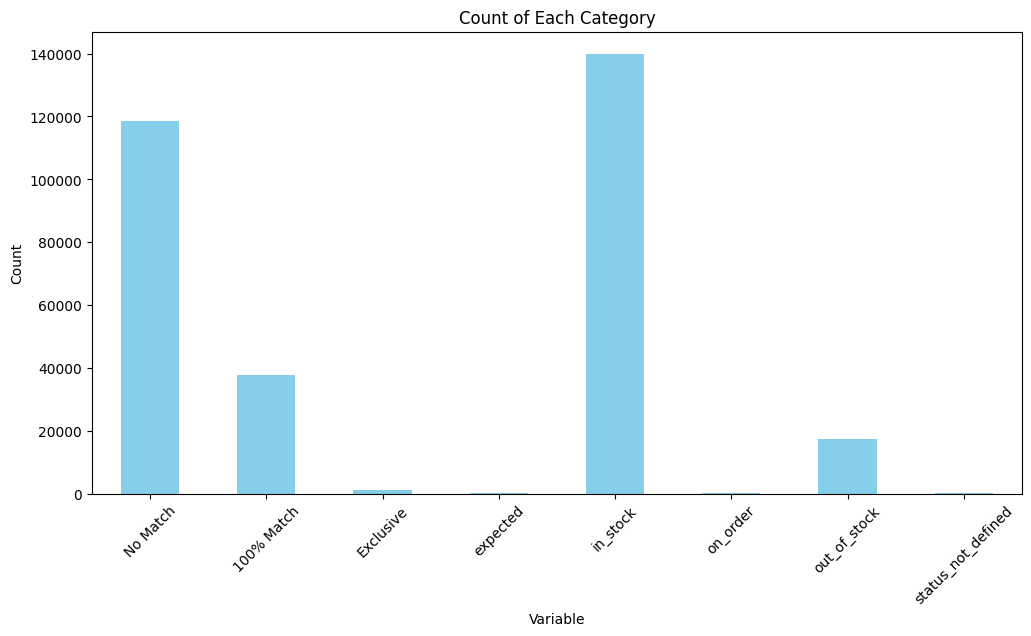

In [26]:

# Checking the distribution of binary status columns
status_columns = ['No Match', '100% Match', 'Exclusive', 'expected', 'in_stock', 'on_order', 'out_of_stock', 'status_not_defined']
status_counts = df_built[status_columns].sum()

# Plotting status distribution
plt.figure(figsize=(12, 6))
status_counts.plot(kind='bar', color='skyblue')
plt.title('Count of Each Category')
plt.xlabel('Variable')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.savefig('plot.png')
plt.show()



We have unbalanced categories, will need to upsample the minority classes 'exclusive', 'expected', 'on_order', and 'status_not_defined'

We have too many brands to do categorical encoding. Will use target (mean) encoding, replacing the brand with the mean price of products of that brand as it will directly link brand to the target.

In [27]:
# Target (mean) encoding for the 'brand' column
brand_mean_price = df_built.groupby('brand')['price'].mean()
df_built['brand_mean_price'] = df_built['brand'].map(brand_mean_price)

# Dropping the original 'brand' column as it is now encoded
df_built = df_built.drop(columns=['brand'])

Missing Values and Percentages:
                       Missing Values  Percentage
match_type                          0    0.000000
category_1                          0    0.000000
category_2                          0    0.000000
category_3                          0    0.000000
category_4                      54741   34.769436
category_5                     140944   89.522358
sku                                 0    0.000000
our_price                      128497   81.616489
price                               0    0.000000
price_before_discount           89927   57.118267
date                                0    0.000000
city                                0    0.000000
competitor                          0    0.000000
No Match                            0    0.000000
100% Match                          0    0.000000
Exclusive                           0    0.000000
expected                            0    0.000000
in_stock                            0    0.000000
on_order          

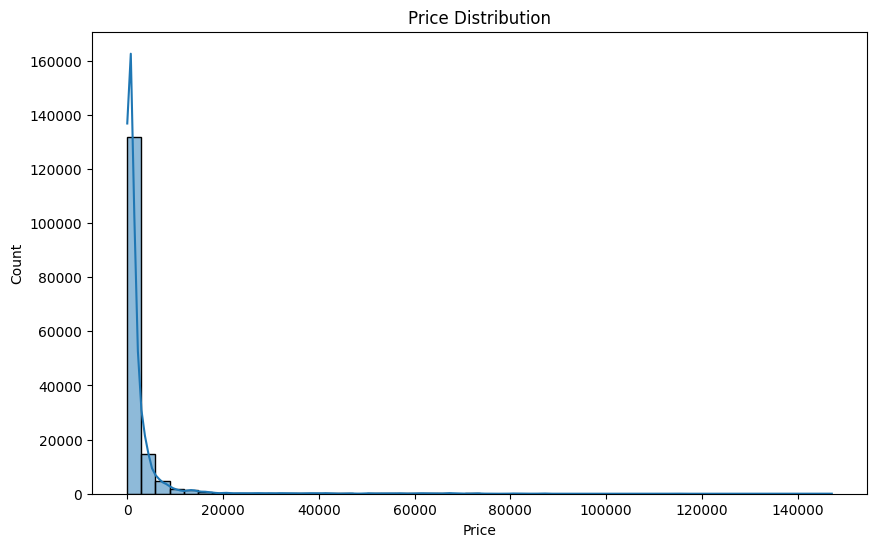

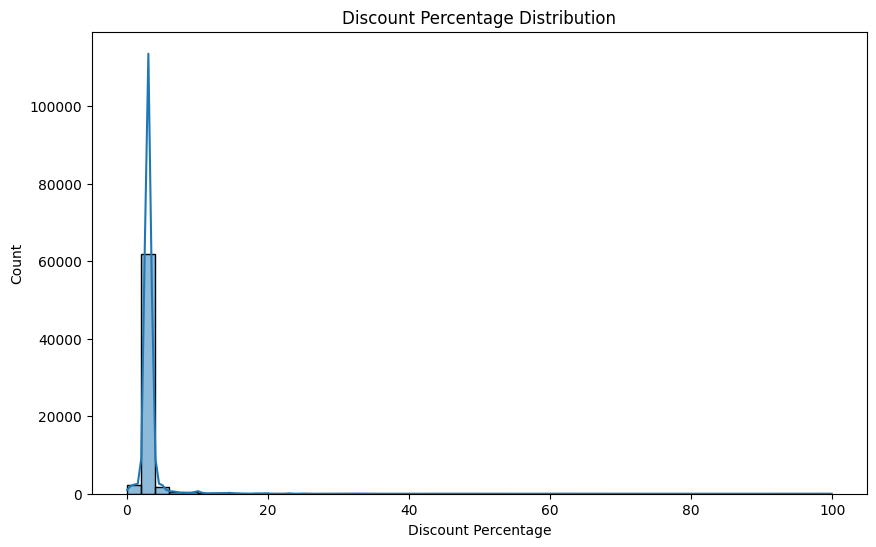

In [28]:
# --- 1. Data Quality Check ---
# Checking for missing values
missing_values = df_built.isnull().sum()
missing_percentage = (missing_values / len(df_built)) * 100
print("Missing Values and Percentages:")
print(pd.DataFrame({'Missing Values': missing_values, 'Percentage': missing_percentage}))

# --- 2. Descriptive Statistics ---
# Basic statistics for numerical columns
print("Descriptive statistics for numerical columns:")
print(df_built[['our_price', 'price', 'price_before_discount']].describe())

# --- 3. Price Comparison Analysis ---
# Creating a new column to calculate discount percentage
df_built['discount_percentage'] = (df_built['price_before_discount'] - df_built['price']) / df_built['price_before_discount'] * 100

# Plot the distribution of prices
plt.figure(figsize=(10, 6))
sns.histplot(df_built['price'], bins=50, kde=True)
plt.title('Price Distribution')
plt.xlabel('Price')
plt.show()

# Plot discount percentage distribution
plt.figure(figsize=(10, 6))
sns.histplot(df_built['discount_percentage'].dropna(), bins=50, kde=True)
plt.title('Discount Percentage Distribution')
plt.xlabel('Discount Percentage')
plt.show()


In [29]:

unique_sku_count = df_built['sku'].nunique()
total_sku_count = len(df_built)
print(f"Number of unique SKU values: {unique_sku_count}")
print(f"Total number of SKU values: {total_sku_count}")
print(f"Percentage of unique SKU values: {unique_sku_count / total_sku_count * 100:.2f}%")



Number of unique SKU values: 6660
Total number of SKU values: 157440
Percentage of unique SKU values: 4.23%


In [30]:
df_built['sku_suffix'] = df_built['sku'].str.extract(r'_(\w+)$')[0]

df_built['default_sku'] = df_built['sku_suffix'].isnull().astype(int)



In [31]:

# Determine the number of unique sku_suffix values
unique_sku_suffix_count = df_built['sku_suffix'].nunique()
print(f"Number of unique SKU suffix values: {unique_sku_suffix_count}")

# One hot encode the sku_suffix column
sku_suffix_dummies = pd.get_dummies(df_built['sku_suffix'], prefix='sku_suffix')
df_built = pd.concat([df_built, sku_suffix_dummies], axis=1)

suffix_colums = ['sku_suffix_компл', 'sku_suffix_м2', 'sku_suffix_м3', 'sku_suffix_паллета', 'sku_suffix_рул', 'sku_suffix_рулон','sku_suffix_упак', 'sku_suffix_шт' ]
df_built[suffix_colums] = df_built[suffix_colums].astype(int)

Number of unique SKU suffix values: 8


In [32]:
# Dropping the original 'sku_suffix' column as it is now encoded
df_built = df_built.drop(columns=['sku_suffix'])

In [33]:
df_built['sku'] = df_built['sku'].str.extract(r'^(\d+)_')[0]

In [34]:
unique_sku_count = df_built['sku'].nunique()
print(f"Number of unique SKU values: {unique_sku_count}")
df_built.describe()

Number of unique SKU values: 5805


,match_type,our_price,price,price_before_discount,city,No Match,100% Match,Exclusive,expected,in_stock,...,discount_percentage,default_sku,sku_suffix_компл,sku_suffix_м2,sku_suffix_м3,sku_suffix_паллета,sku_suffix_рул,sku_suffix_рулон,sku_suffix_упак,sku_suffix_шт
count,157440.000000,28943.000000,157440.000000,67513.000000,157440.0,157440.000000,157440.000000,157440.000000,157440.000000,157440.000000,...,67513.000000,157440.000000,157440.000000,157440.000000,157440.000000,157440.000000,157440.000000,157440.000000,157440.000000,157440.000000
mean,0.252757,1397.909912,2355.168213,1838.401611,1.0,0.753989,0.239266,0.006745,0.000318,0.889285,...,3.361251,0.166241,0.000025,0.099511,0.006091,0.000476,0.061293,0.000191,0.123984,0.542188
std,0.449848,1957.484741,7036.827637,3863.724854,0.0,0.430686,0.426637,0.081853,0.017818,0.313780,...,3.244039,0.372298,0.005040,0.299348,0.077808,0.021821,0.239868,0.013803,0.329564,0.498219
min,0.000000,9.000000,0.000000,3.100000,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.058824,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,378.000000,279.929993,408.000000,1.0,1.000000,0.000000,0.000000,0.000000,1.000000,...,2.904721,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,745.000000,789.000000,880.000000,1.0,1.000000,0.000000,0.000000,0.000000,1.000000,...,2.951699,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,0.000000,1608.000000,1881.219971,1804.000000,1.0,1.000000,0.000000,0.000000,0.000000,1.000000,...,3.351955,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,2.000000,18730.000000,147100.000000,131470.000000,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,...,99.923721,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [35]:
# Performing numerical analysis, getting datatypes, and finding min and max values of numerical and date columns
numerical_analysis = df_built.describe()
datatypes = df_built.dtypes
min_max_values = {
    "Numerical": numerical_analysis.loc[['min', 'max']],
    "Date": {
        "min": df_built['date'].min(),
        "max": df_built['date'].max()
    }
}

unique_sku_count, datatypes, min_max_values

(5805,
 match_type                  int8
 category_1                object
 category_2                object
 category_3                object
 category_4                object
 category_5                object
 sku                       object
 our_price                float32
 price                    float32
 price_before_discount    float32
 date                      object
 city                        int8
 competitor                object
 No Match                   int64
 100% Match                 int64
 Exclusive                  int64
 expected                   int64
 in_stock                   int64
 on_order                   int64
 out_of_stock               int64
 status_not_defined         int64
 brand_mean_price         float32
 discount_percentage      float32
 default_sku                int64
 sku_suffix_компл           int64
 sku_suffix_м2              int64
 sku_suffix_м3              int64
 sku_suffix_паллета         int64
 sku_suffix_рул             int64
 sku_su

In [36]:
# Calculate the number of unique values in the 'sku' column
unique_sku_count = df_built['sku'].nunique()
print(f"Number of unique SKU values: {unique_sku_count}")

# Convert the 'sku' column to float32
df_built['sku'] = df_built['sku'].astype('float32')

# Verify the datatype conversion
print(df_built.dtypes)


Number of unique SKU values: 5805
match_type                  int8
category_1                object
category_2                object
category_3                object
category_4                object
category_5                object
sku                      float32
our_price                float32
price                    float32
price_before_discount    float32
date                      object
city                        int8
competitor                object
No Match                   int64
100% Match                 int64
Exclusive                  int64
expected                   int64
in_stock                   int64
on_order                   int64
out_of_stock               int64
status_not_defined         int64
brand_mean_price         float32
discount_percentage      float32
default_sku                int64
sku_suffix_компл           int64
sku_suffix_м2              int64
sku_suffix_м3              int64
sku_suffix_паллета         int64
sku_suffix_рул             int64
sku_suffi

In [37]:
v0 = df_built.drop(columns=['price_before_discount', 'our_price', 'discount_percentage'])
v0 = v0.dropna(subset=['brand_mean_price'])


In [38]:
v0.head()

,match_type,category_1,category_2,category_3,category_4,category_5,sku,price,date,city,...,brand_mean_price,default_sku,sku_suffix_компл,sku_suffix_м2,sku_suffix_м3,sku_suffix_паллета,sku_suffix_рул,sku_suffix_рулон,sku_suffix_упак,sku_suffix_шт
0,1,s,"s, draining systems",skulls and components,skulls set,None,600877.0,137.940002,2024-10-07,1,...,1844.824341,0,0,1,0,0,0,0,0,0
2,1,s,"s, draining systems",and zinc sheets,s and components,None,106644.0,639.130005,2024-10-07,1,...,587.313782,0,0,1,0,0,0,0,0,0
6,1,s,"s, draining systems",skulls and components,skulls set,None,102537.0,1199.000000,2024-10-07,1,...,3932.471191,0,0,1,0,0,0,0,0,0
7,1,s,"s, draining systems",skulls and components,skulls set,None,102536.0,1199.000000,2024-10-07,1,...,6604.583496,0,0,1,0,0,0,0,0,0
9,1,s,"s, draining systems",skulls and components,skulls set,None,140094.0,315.350006,2024-10-07,1,...,624.825500,0,0,1,0,0,0,0,0,0


In [39]:
"""

v0['date'] = pd.to_datetime(v0['date'])
v0 = v0.sort_values('date').reset_index(drop=True)


y = v0['price']
X = v0.drop(['price'], axis=1)
X = X.drop('date', axis=1, errors='ignore')

train_size = 0.7
val_size = 0.15
test_size = 0.15
n = len(v0)
train_end = int(n * train_size)
val_end = int(n * (train_size + val_size))

X_train = X.iloc[:train_end]
y_train = y.iloc[:train_end]

X_val = X.iloc[train_end:val_end]
y_val = y.iloc[train_end:val_end]

X_test = X.iloc[val_end:]
y_test = y.iloc[val_end:]


categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])


model = Pipeline(steps=[
    ('regressor', RandomForestRegressor(random_state=42))
])

# 7. Hyperparameter tuning
param_grid = {
    'regressor__n_estimators': [100, 200, 500],
    'regressor__max_depth': [None, 10, 20, 30],
    'regressor__min_samples_split': [2, 5, 10],
    'regressor__min_samples_leaf': [1, 2, 4],
    'regressor__max_features': ['auto', 'sqrt', 'log2']
}

tscv = TimeSeriesSplit(n_splits=5)
grid_search = GridSearchCV(model, param_grid, cv=tscv, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train, y_train)

print("Best parameters found: ", grid_search.best_params_)

# 8. Evaluate the model
best_model = grid_search.best_estimator_

# Validation set
val_predictions = best_model.predict(X_val)
mse_val = mean_squared_error(y_val, val_predictions)
rmse_val = np.sqrt(mse_val)
mae_val = mean_absolute_error(y_val, val_predictions)
r2_val = r2_score(y_val, val_predictions)

print(f'Validation RMSE: {rmse_val}')
print(f'Validation MAE: {mae_val}')
print(f'Validation R²: {r2_val}')

# Test set
test_predictions = best_model.predict(X_test)
mse_test = mean_squared_error(y_test, test_predictions)
rmse_test = np.sqrt(mse_test)
mae_test = mean_absolute_error(y_test, test_predictions)
r2_test = r2_score(y_test, test_predictions)

print(f'Test RMSE: {rmse_test}')
print(f'Test MAE: {mae_test}')
print(f'Test R²: {r2_test}')
"""


'\n\nv0[\'date\'] = pd.to_datetime(v0[\'date\'])\nv0 = v0.sort_values(\'date\').reset_index(drop=True)\n\n\ny = v0[\'price\']\nX = v0.drop([\'price\'], axis=1)\nX = X.drop(\'date\', axis=1, errors=\'ignore\')\n\ntrain_size = 0.7\nval_size = 0.15\ntest_size = 0.15\nn = len(v0)\ntrain_end = int(n * train_size)\nval_end = int(n * (train_size + val_size))\n\nX_train = X.iloc[:train_end]\ny_train = y.iloc[:train_end]\n\nX_val = X.iloc[train_end:val_end]\ny_val = y.iloc[train_end:val_end]\n\nX_test = X.iloc[val_end:]\ny_test = y.iloc[val_end:]\n\n\ncategorical_transformer = Pipeline(steps=[\n    (\'onehot\', OneHotEncoder(handle_unknown=\'ignore\', sparse_output=False))\n])\n\n\nmodel = Pipeline(steps=[\n    (\'regressor\', RandomForestRegressor(random_state=42))\n])\n\n# 7. Hyperparameter tuning\nparam_grid = {\n    \'regressor__n_estimators\': [100, 200, 500],\n    \'regressor__max_depth\': [None, 10, 20, 30],\n    \'regressor__min_samples_split\': [2, 5, 10],\n    \'regressor__min_samples

In [131]:
df_built.describe()

,our_price,price,price_before_discount,No Match,100% Match,Exclusive,expected,in_stock,on_order,out_of_stock,...,brand_mean_price,discount_percentage,sku_suffix_компл,sku_suffix_м2,sku_suffix_м3,sku_suffix_паллета,sku_suffix_рул,sku_suffix_рулон,sku_suffix_упак,sku_suffix_шт
count,28943.000000,157440.000000,67513.000000,157440.000000,157440.000000,157440.000000,157440.000000,157440.000000,157440.000000,157440.000000,...,55355.000000,67513.000000,157440.000000,157440.000000,157440.000000,157440.000000,157440.000000,157440.000000,157440.000000,157440.000000
mean,1397.909912,2355.168213,1838.401611,0.753989,0.239266,0.006745,0.000318,0.889285,0.000502,0.109654,...,1396.393311,3.361251,0.000025,0.099511,0.006091,0.000476,0.061293,0.000191,0.123984,0.542188
std,1957.484741,7036.827637,3863.724854,0.430686,0.426637,0.081853,0.017818,0.313780,0.022395,0.312460,...,1207.101929,3.244039,0.005040,0.299348,0.077808,0.021821,0.239868,0.013803,0.329564,0.498219
min,9.000000,0.000000,3.100000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.058824,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,378.000000,279.929993,408.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,...,815.138184,2.904721,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,745.000000,789.000000,880.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,...,949.384338,2.951699,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,1608.000000,1881.219971,1804.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,...,1514.574097,3.351955,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,18730.000000,147100.000000,131470.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,14030.003906,99.923721,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [132]:
df_combined = pd.concat([df_petrovich, df_leroy], ignore_index=True)


In [133]:
print("Combined DataFrame shape:", df_combined.shape)


Combined DataFrame shape: (44102983, 15)


In [134]:
print("Data Types:")
print(df_combined.dtypes)


Data Types:
match_type                  int8
category_1                object
category_2                object
category_3                object
category_4                object
category_5                object
sku                       object
brand                     object
our_price                float32
price                    float32
price_before_discount    float32
date                      object
city                        int8
status                      int8
competitor                object
dtype: object


In [135]:
print("Missing Values:")
print(df_combined.isnull().sum())


Missing Values:
match_type                      0
category_1                1580929
category_2               15698601
category_3               22410160
category_4               42703640
category_5               43828512
sku                             0
brand                    35863928
our_price                43768076
price                           0
price_before_discount    39562536
date                            0
city                            0
status                          0
competitor                      0
dtype: int64


In [136]:
df_combined = df_combined.drop(columns=['city'])

In [137]:
df_combined = df_combined.drop(columns=['category_5', 'category_4', 'category_3', 'category_2', 'category_1'])

In [138]:
df_combined.head()

,match_type,sku,brand,our_price,price,price_before_discount,date,status,competitor
0,1,600877_м2,ТЕХНОНИКОЛЬ,2049.0,137.940002,NaN,2024-10-07,1,petrovich
1,1,106643_м2,None,NaN,673.469971,NaN,2024-10-07,1,petrovich
2,1,106644_м2,КОРИЧНЕВЫЙ,NaN,639.130005,NaN,2024-10-07,1,petrovich
3,1,143965_м2,None,NaN,630.320007,NaN,2024-10-07,1,petrovich
4,1,106642_м2,None,NaN,543.039978,NaN,2024-10-07,1,petrovich


In [139]:
unique_values_petrovich = df_petrovich['category_1'].nunique()
unique_values_leroy = df_leroy['category_1'].nunique()

print(f"Number of unique values in category_1 for Petrovich: {unique_values_petrovich}")
print(f"Number of unique values in category_1 for Leroy: {unique_values_leroy}")


Number of unique values in category_1 for Petrovich: 237
Number of unique values in category_1 for Leroy: 6813
